In [172]:
import pandas as pd

In [173]:
df_cm = pd.read_csv('../processed/Engelerschans.csv')
df_m3 = pd.read_csv('../processed/data_sewer_data_db_004 Engelerschans - debieten - 09-2020 - 08-2020.csv')
# df_rain = pd.read_csv('../processed/data_rainfall_rain_timeseries_Download__.csv')

In [174]:
df_cm['Unnamed: 0'] = pd.to_datetime(df_cm['Unnamed: 0'])
df_cm = df_cm.set_index('Unnamed: 0')
df_cm['neg_diff'] = df_cm['level_diff']
df_cm['pos_diff'] = df_cm['level_diff']
df_cm.loc[df_cm['neg_diff'] > 0, 'neg_diff'] = 0
df_cm.loc[df_cm['pos_diff'] < 0, 'pos_diff'] = 0
df_m3['DAG'] = pd.to_datetime(df_m3['DAG'])
df_m3 = df_m3.set_index('DAG')

In [175]:
df_cm = df_cm.groupby(pd.Grouper(freq='D')).sum()

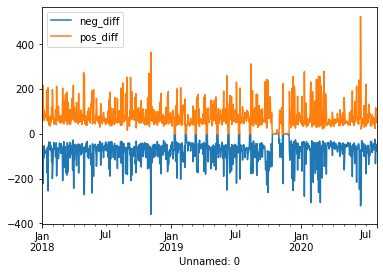

In [176]:
df_cm.plot(None, ['neg_diff', 'pos_diff'])

In [177]:
df_rain['index'] = pd.to_datetime(df_rain['Begin'])
df_rain = df_rain.set_index('index')
df_rain = df_rain.groupby(pd.Grouper(freq='D')).sum()

In [178]:
df_rain['Total'] = df_rain.sum(axis=1)

In [179]:
concat = pd.concat([df_cm, df_rain], axis=1)
concat = concat[concat['level_diff'].notna()]

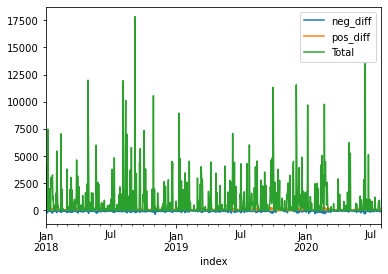

In [180]:
concat.plot(None, ['neg_diff', 'pos_diff', 'Total'])

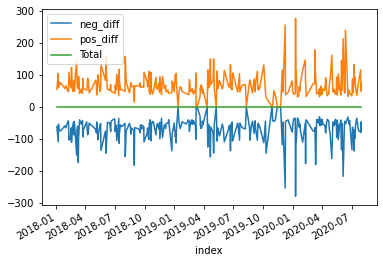

In [181]:
concat.loc[concat['Total'] == 0].plot(None, ['neg_diff', 'pos_diff', 'Total'])

In [182]:
concat_m3 = pd.concat([concat, df_m3], axis=1) 


In [201]:
concat_m32 = concat_m3[concat_m3['DEBIET ACTUEEL - 1 - M3/H - GEMIDDELDE'].notna() & concat_m3['Total'].notna()]
concat_m32['debiet'] = concat_m32['DEBIET ACTUEEL - 1 - M3/H - GEMIDDELDE'].str.replace('-','0')
concat_m32['debiet'] = pd.to_numeric(concat_m32['debiet'])

<ipython-input-201-ed5a1e27a4f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_m32['debiet'] = concat_m32['DEBIET ACTUEEL - 1 - M3/H - GEMIDDELDE'].str.replace('-','0')
<ipython-input-201-ed5a1e27a4f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_m32['debiet'] = pd.to_numeric(concat_m32['debiet'])


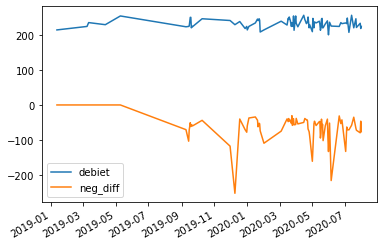

In [209]:
concat_m32.loc[(concat_m32['Total'] == 0) & (concat_m32['debiet'] != 0)].plot(None, ['debiet', 'neg_diff'])

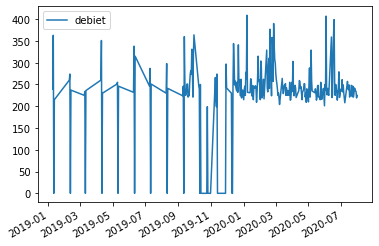

In [207]:
concat_m32.plot(None, ['debiet'])

In [211]:
concat_m32['004: Engelerschans Niveau trend niveau DWA(cm)'] = concat_m32['004: Engelerschans Niveau trend niveau DWA(cm)']/24

<ipython-input-211-dd83d5b300ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat_m32['004: Engelerschans Niveau trend niveau DWA(cm)'] = concat_m32['004: Engelerschans Niveau trend niveau DWA(cm)']/24


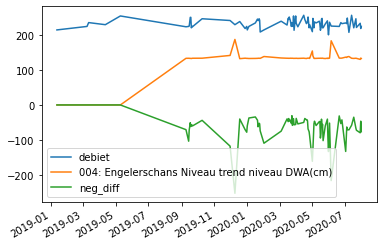

In [213]:
concat_m32.loc[(concat_m32['Total'] == 0) & (concat_m32['debiet'] != 0)].plot(None, ['debiet', '004: Engelerschans Niveau trend niveau DWA(cm)', 'neg_diff'])

In [214]:
concat_m32['004: Engelerschans Niveau trend niveau DWA(cm)'].mean()

112.57111519904603